In [121]:
# Installations
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# TODO: joins - concatenate all unchanged info throughout the years to one dataframe and leave all the others to the different dfs, merge those,
# see if the candidate changed their party throughout the years, merge it back based on names
# TODO: add years during df importing
# Feature engineering!
# wide df for clustering, long for classification (drop the duplicates?)

## Import knihoven a inicializace potřebných funkcí

In [122]:
# Packages importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.catch_warnings(record=True)
warnings.simplefilter("ignore")
plt.rc("figure", figsize=(10,6))

In [123]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/rmnskb/cz-elections/main/dict_occupations.json"
response = urllib.request.urlopen(url)
encoding = response.info().get_content_charset("utf-8")
occup_dict = json.loads(response.read().decode(encoding))

def obor(val: str) -> str:
    """
    Checks to what field does candidate's profession belongs to (such as finance, law, medicine etc.) with the help of keywords from global occup_dict dictionary
    :param val: string value containing candidate's profession description
    :return: string value with the particular field, returns "Jiné" if no matches were found
    """
    global occup_dict
    for key in occup_dict.keys():
        for i in occup_dict[key]["var"]:
            if i in val:
                return occup_dict[key]["name"]
    return "Jiné"

occup_dict.keys()

dict_keys(['duchod', 'podnik', 'zivnost', 'remeslo', 'soukzam', 'finance', 'student', 'akademik', 'statzam', 'zdravotnictvi', 'politik', 'nezam', 'manager', 'zemedel', 'naboz', 'pravo', 'odbor', 'umeni', 'sport', 'nezaraz'])

In [139]:
def mandat(val: str) -> int:
    """
    Map value of mandates. 0 stands for no mandate, 1 stands for mandate. The function exists because there different formattings: in some years it is A or N, in other years it's 0 or 1
    :param val: string value
    :return: integer value 0 or 1
    """
    if val == "A" or val == "1":
        return 1
    elif val == "N" or val == "0":
        return 0

In [140]:
def clean_data(data: pd.DataFrame, strany: dict) -> pd.DataFrame:
    """
    Clean and prepare a dataframe containing data from different types of elections for further visualisation and modelling purposes.
    The output is:
        -[cele_jmeno]: combining name columns into one
        -[vek]: candidate's age
        -[vs_vzdelani]: Creating a boolean column checking whether a candidate has university degree
        -[obor]: field of candidate's profession
        -[pohlavi]: candidate's gender (based on their surname's ending)
        -[kraj]: region where candidate runs their campaign
        -[NSTRANA]: political party that nominated the candidate
        -[ideologie]: canidate's ideology (left-wing, center, right-wing)
        -[procento]: relative measure of votes for the candidate
        -[mandat]: whether candidate got their mandate
        -[year]: year of elections
    :param data: pandas dataframe including elections data
    :param strany: dictionary data type with political parties' data
    :return: cleaned pandas dataframe
    """
    df = data.copy()

    df["cele_jmeno"] = df["JMENO"] + " " + df["PRIJMENI"]
    df["pohlavi"] = np.where(df.loc[:, "cele_jmeno"].str[-1] == "á", "F", "M")
    df["vs_vzdelani"] = np.where((df["TITULPRED"].notnull()) | (df["TITULZA"].notnull()), 1, 0)
    df["vek"] = df["VEK"]
    # Místo PSTRANA jsem vzal NSTRANA, jelikož u té první je hodně None
    # TODO: drop the rows with NA (only the year 2006 has 5% NA values, others are relatively good with it)
    kraj_list = ["Hlavní město Praha", "Středočeský kraj", "Jihočeský kraj", "Plzeňský kraj", "Karlovarský kraj",
                "Ústecký kraj", "Liberecký kraj", "Královéhradecký kraj", "Pardubický kraj", "Kraj Vysočina",
                "Jihomoravský kraj", "Olomoucký kraj", "Zlínský kraj", "Moravskoslezský kraj"]
    kraj_dict = dict(zip(list(range(1, 15)), kraj_list))
    df["ideologie"] = df["NSTRANA"].map(strany)
    df["kraj"] = df["VOLKRAJ"].map(kraj_dict)
    df["obor"] = df["POVOLANI"].apply(lambda row: obor(str(row)))
    df["mandat"] = df["MANDAT"].apply(lambda row: mandat(str(row)))
    df["procento"] = df["POCPROC"]
    columns = ["cele_jmeno", "vek", "vs_vzdelani", "obor", "pohlavi", "kraj", "NSTRANA", "ideologie", "procento", "mandat", "year"]

    return df[columns]

## Načtení dat

In [125]:
snem_list = []
snem_years = [2006, 2010, 2013, 2017, 2021]
for year in snem_years:
    temp_df = pd.read_csv(f"https://raw.githubusercontent.com/rmnskb/cz-elections/main/legislative-elections/snem_{year}.csv",
                          sep=";", encoding="utf-8")
    temp_df["year"] = year
    snem_list.append(temp_df)

snem_list[0].head(20)

,VOLKRAJ,KSTRANA,PORCISLO,JMENO,PRIJMENI,TITULPRED,TITULZA,VEK,POVOLANI,BYDLISTEN,...,NSTRANA,PLATNOST,POCHLASU,POCPROC,POCPROCVSE,MANDAT,PORADIMAND,PORADINAHR,CPU,year
0,14,6,1,František,Zwyrtek,NaN,NaN,45,předseda hnutí,Český Těšín,...,88,0,120,0.0,2.86,0,0,0,NaN,2006
1,14,6,2,Vladimír,Mach,RNDr.,NaN,63,středoškolský profesor,Havířov,...,88,0,93,0.0,2.21,0,0,0,NaN,2006
2,14,6,3,Zdeněk,Stolař,PhDr.,NaN,51,psycholog,Frýdek-Místek,...,88,0,137,0.0,3.26,0,0,0,NaN,2006
3,14,6,4,Alena,Hasáková,PhDr.,NaN,51,středoškolský profesor,Český Těšín,...,88,0,124,0.0,2.95,0,0,0,NaN,2006
4,14,6,5,Alois,Čtvrtníček,Ing.,CSc.,60,podnikatel,Bruntál,...,88,0,35,0.0,0.83,0,0,0,NaN,2006
5,14,6,6,Hana,Doležalová,Mgr.,NaN,33,učitelka,Ostrava,...,88,0,81,0.0,1.93,0,0,0,NaN,2006
6,14,6,7,Václav,Kafka,Doc. Ing.,CSc.,63,výzkumný pracovník,Orlová,...,88,0,76,0.0,1.81,0,0,0,NaN,2006
7,14,6,8,Libuše,Koppová,NaN,NaN,59,zdravotní sestra,Třinec,...,88,0,95,0.0,2.26,0,0,0,NaN,2006
8,14,6,9,Alexander,Nedbálek,MUDr.,NaN,51,lékař,Havířov,...,88,0,48,0.0,1.14,0,0,0,NaN,2006
9,14,6,10,Jan,Fismol,Bc.,NaN,59,místostarosta,Dolní Lutyně,...,88,0,56,0.0,1.33,0,0,0,NaN,2006


In [126]:
strany = pd.read_csv("https://raw.githubusercontent.com/rmnskb/cz-elections/main/legislative-elections/strany.csv",
                    sep=";", encoding="utf-8")
strany_dict = dict(zip(strany["VSTRANA"], strany["Ideologie"]))
strany.head()

,VSTRANA,NAZEVCELK,ZKRATKAK8,Ideologie
0,1,Křesťanská a demokratická unie - Československ...,KDU-ČSL,Střed
1,2,Česká strana národně sociální,ČSNS,Levice
2,5,Strana zelených,SZ,Levice
3,7,Česká strana sociálně demokratická,ČSSD,Levice
4,11,Sdružení pro republiku-Republikánská strana Če...,SPR-RSČ,Pravice


In [141]:
snem_clean_list = []

for i in range(5):
    temp_df = clean_data(snem_list[i], strany_dict)
    snem_clean_list.append(temp_df)

snem_clean_list[0].head(20)

,cele_jmeno,vek,vs_vzdelani,obor,pohlavi,kraj,NSTRANA,ideologie,procento,mandat,year
0,František Zwyrtek,45,0,manažer,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
1,Vladimír Mach,63,1,Jiné,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
2,Zdeněk Stolař,51,1,zaměstnanec ve zdravotnictví,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
3,Alena Hasáková,51,1,Jiné,F,Moravskoslezský kraj,88,Střed,0.0,0,2006
4,Alois Čtvrtníček,60,1,podnikatel,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
5,Hana Doležalová,33,1,státní zaměstnanec,F,Moravskoslezský kraj,88,Střed,0.0,0,2006
6,Václav Kafka,63,1,Jiné,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
7,Libuše Koppová,59,0,zaměstnanec ve zdravotnictví,F,Moravskoslezský kraj,88,Střed,0.0,0,2006
8,Alexander Nedbálek,51,1,zaměstnanec ve zdravotnictví,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
9,Jan Fismol,59,1,politik,M,Moravskoslezský kraj,88,Střed,0.0,0,2006


In [143]:
for index, year in enumerate(snem_years):
    snem_clean_list[index]["year"] = year

snem_long = pd.concat(snem_clean_list, ignore_index=True)
snem_long.tail(10)

,cele_jmeno,vek,vs_vzdelani,obor,pohlavi,kraj,NSTRANA,ideologie,procento,mandat,year
28768,Michal Havlík,42.0,0,podnikatel,M,Moravskoslezský kraj,83.0,Pravice,"0,42",0,2021
28769,Michaela Hanzlík Skarabellová,51.0,0,manažer,F,Moravskoslezský kraj,83.0,Pravice,"0,77",0,2021
28770,Jiří Minařík,51.0,0,manažer,M,Moravskoslezský kraj,83.0,Pravice,"1,16",0,2021
28771,Vladimír Herout,62.0,0,Jiné,M,Moravskoslezský kraj,83.0,Pravice,"0,74",0,2021
28772,František Kolínek,43.0,0,zaměstnanec v soukromém sektoru,M,Moravskoslezský kraj,83.0,Pravice,"0,38",0,2021
28773,Roman Zvoníček,46.0,0,zaměstnanec v soukromém sektoru,M,Moravskoslezský kraj,83.0,Pravice,"0,31",0,2021
28774,Tomáš Kleibl,25.0,0,zaměstnanec v soukromém sektoru,M,Moravskoslezský kraj,83.0,Pravice,"0,88",0,2021
28775,Alois Nezbeda,77.0,0,Jiné,M,Moravskoslezský kraj,83.0,Pravice,"0,81",0,2021
28776,Jiří Žváček,58.0,0,zaměstnanec v soukromém sektoru,M,Moravskoslezský kraj,83.0,Pravice,"0,49",0,2021
28777,Petr Srovnal,61.0,0,zaměstnanec v soukromém sektoru,M,Moravskoslezský kraj,83.0,Pravice,"0,7",0,2021


## Ošetření chybějících hodnot

In [144]:
print("Počet chybějících hodnot v každém sloupci:\n")
print(snem_long.isnull().sum())
print("-" * 40)
print("Nejčastější ideologie kandidátů:\n")
print(snem_long["ideologie"].value_counts())

Počet chybějících hodnot v každém sloupci:

cele_jmeno        0
vek              11
vs_vzdelani       0
obor              0
pohlavi           0
kraj              0
NSTRANA          11
ideologie       214
procento       2959
mandat            0
year              0
dtype: int64
----------------------------------------
Nejčastější ideologie kandidátů:

Pravice    14370
Levice      7505
Střed       6689
Name: ideologie, dtype: int64


In [145]:
# Missing values in "vek" will be deleted, since these are non-existent candidates
# All missing values in "ideologie" will be assigned to Pravice, since it's the most frequent value
# All missing columns in "procento" will be set to 0

snem_long = snem_long.dropna(subset=["vek"])
snem_long.ideologie = snem_long.ideologie.fillna("Pravice")
snem_long.procento = snem_long.procento.fillna(0)

print("Stav po ošetření chybějících hodnot:")
print("Počet chybějících hodnot v každém sloupci:\n")
print(snem_long.isnull().sum())
print("-" * 40)
print("Nejčastější ideologie kandidátů:\n")
print(snem_long["ideologie"].value_counts())

Stav po ošetření chybějících hodnot:
Počet chybějících hodnot v každém sloupci:

cele_jmeno     0
vek            0
vs_vzdelani    0
obor           0
pohlavi        0
kraj           0
NSTRANA        0
ideologie      0
procento       0
mandat         0
year           0
dtype: int64
----------------------------------------
Nejčastější ideologie kandidátů:

Pravice    14573
Levice      7505
Střed       6689
Name: ideologie, dtype: int64


## Exploratorní analýza

In [131]:
snem_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28767 entries, 0 to 28777
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cele_jmeno   28767 non-null  object 
 1   vek          28767 non-null  float64
 2   vs_vzdelani  28767 non-null  int64  
 3   obor         28767 non-null  object 
 4   pohlavi      28767 non-null  object 
 5   kraj         28767 non-null  object 
 6   NSTRANA      28767 non-null  float64
 7   ideologie    28767 non-null  object 
 8   procento     28767 non-null  object 
 9   mandat       12797 non-null  float64
 10  year         28767 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 2.6+ MB


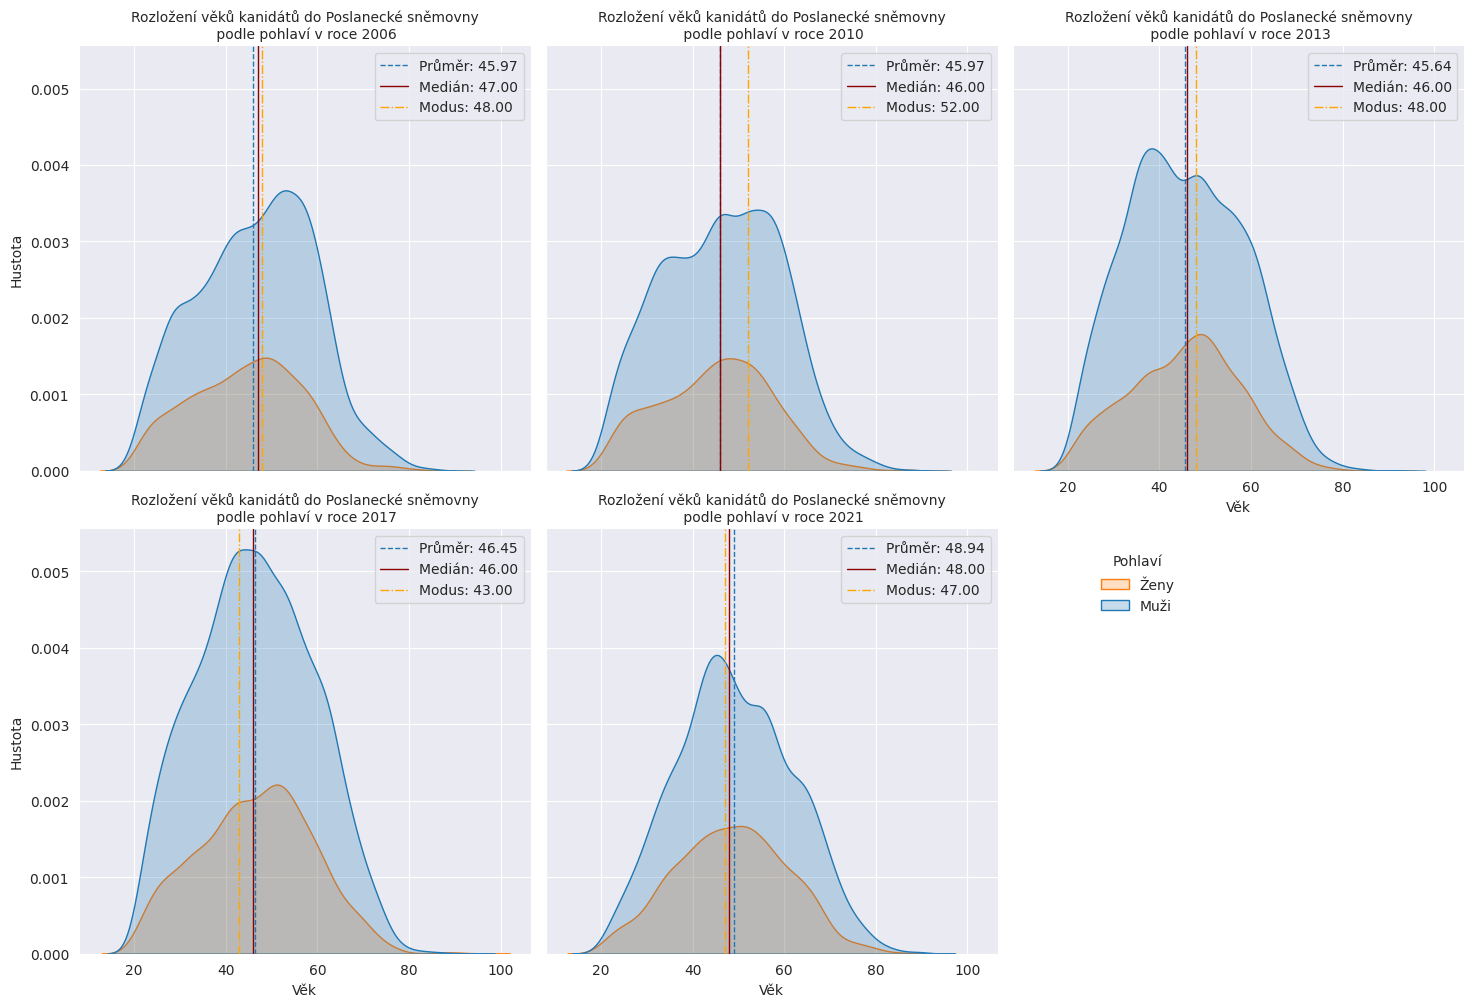

In [132]:
g = sns.displot(
        data=snem_long, x="vek", hue="pohlavi", kind="kde", fill=True, legend=True, col="year", col_wrap=3
    )
g.set_titles("Rozložení věků kanidátů do Poslanecké sněmovny\n podle pohlaví v roce {col_name}")
g.set(xlabel="Věk", ylabel="Hustota")
sns.move_legend(g, "upper left", bbox_to_anchor=(.70, .47), title="Pohlaví", labels=["Ženy", "Muži"]);

years_avgs = {}
for i, year in enumerate(snem_years):
    years_avgs[i] = [snem_long.query(f"year == {year}")["vek"].mean(),
                     snem_long.query(f"year == {year}")["vek"].median(),
                     snem_long.query(f"year == {year}")["vek"].mode().iat[0]]

axes = g.axes.flatten()
for i, ax in enumerate(axes):
    ax.axvline(years_avgs[i][0], ls="--", lw=1.0, label=f"""Průměr: {years_avgs[i][0]:.2f}""")
    ax.axvline(years_avgs[i][1], color="darkred", lw=1.0, label=f"""Medián: {years_avgs[i][1]:.2f}""")
    ax.axvline(years_avgs[i][2], ls="-.", color="orange", lw=1.0, label=f"""Modus: {years_avgs[i][2]:.2f}""")
    ax.legend(loc=0)

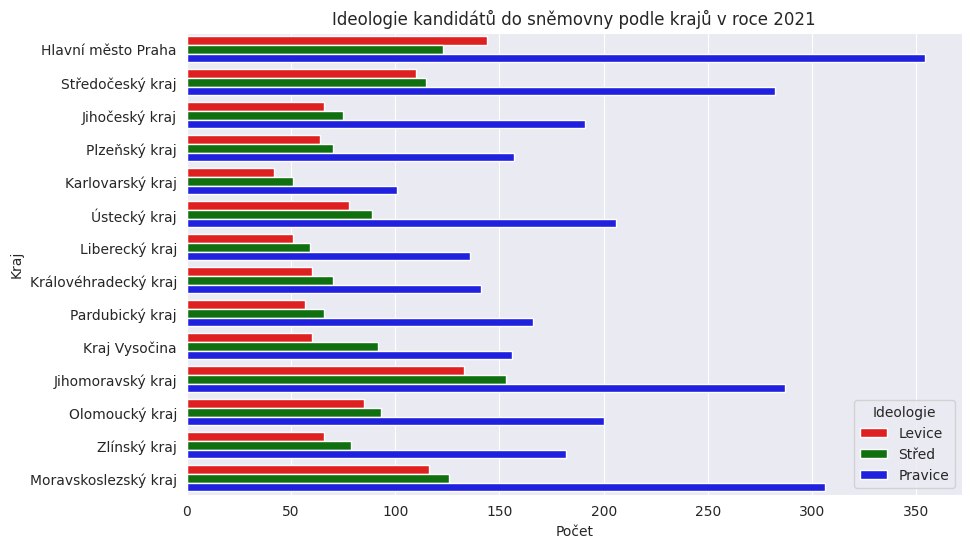

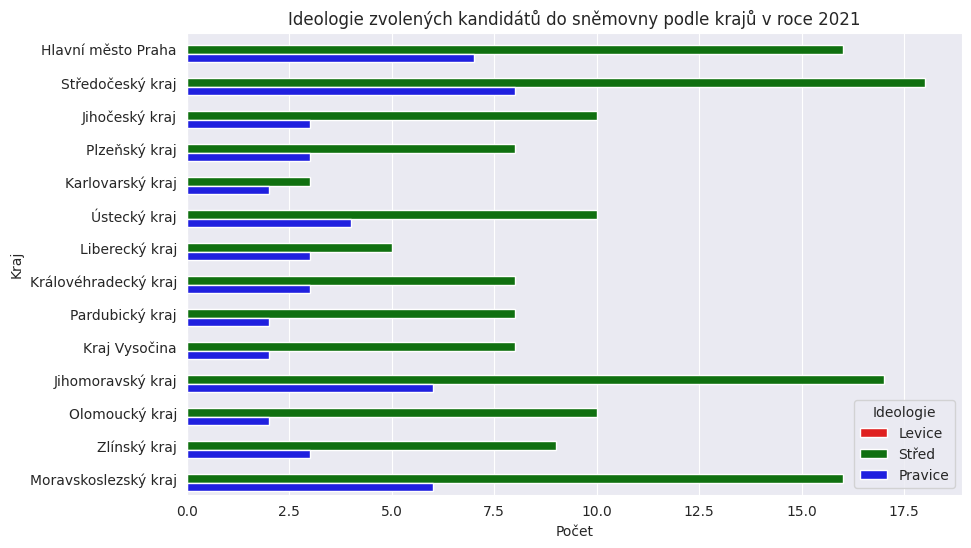

In [133]:
# First plot
hue_order = ["Levice", "Střed", "Pravice"]
hue_palette = ["Red", "Green", "Blue"]

sns.countplot(snem_clean_list[4], y="kraj", hue="ideologie",
              hue_order=hue_order, palette=hue_palette)
# plt.xticks(rotation=90)
plt.title("Ideologie kandidátů do sněmovny podle krajů v roce 2021")
plt.xlabel("Počet")
plt.ylabel("Kraj")
plt.legend(title="Ideologie")
plt.show();

# Second plot
sns.countplot(snem_clean_list[4][snem_clean_list[4]["mandat"] == 1], y="kraj", hue="ideologie",
              hue_order=hue_order, palette=hue_palette)
# plt.xticks(rotation=90)
plt.title("Ideologie zvolených kandidátů do sněmovny podle krajů v roce 2021")
plt.xlabel("Počet")
plt.ylabel("Kraj")
plt.legend(title="Ideologie")
plt.show();

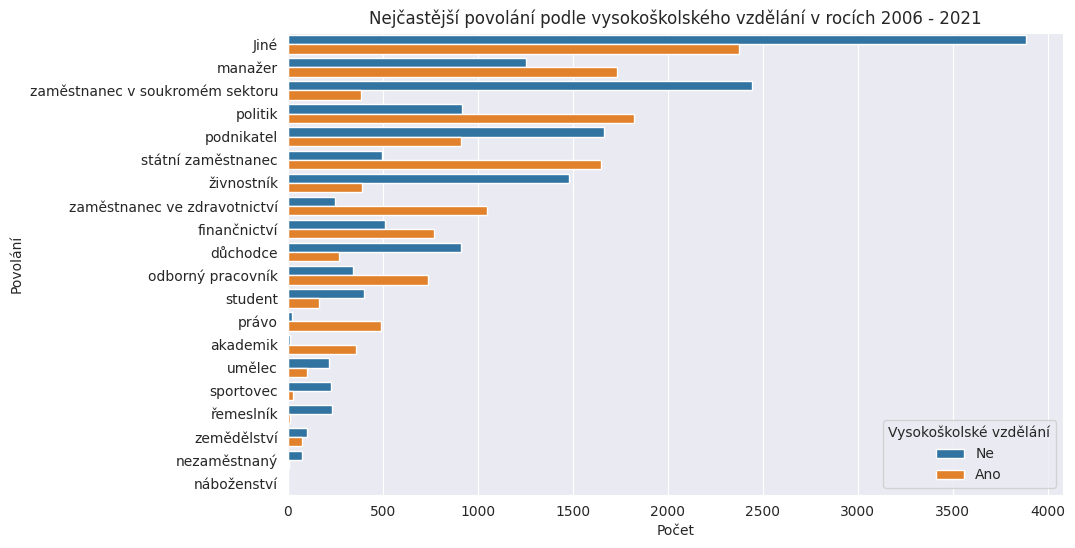

In [134]:
g = sns.countplot(
    data=snem_long, y="obor", hue="vs_vzdelani",
    order=snem_long.obor.value_counts().index
)
plt.title("Nejčastější povolání podle vysokoškolského vzdělání v rocích 2006 - 2021")
plt.xlabel("Počet")
plt.ylabel("Povolání")
plt.legend(title="Vysokoškolské vzdělání",
           labels=["Ne", "Ano"]);

In [135]:
for i in range(5):
    snem_list[i]["obor"] = snem_list[i]["POVOLANI"].apply(lambda row: obor(str(row)))

snem = pd.concat(snem_list, ignore_index=True)

In [136]:
print(snem[snem["obor"] == "Jiné"]["POVOLANI"].value_counts().index[:100].to_list())

['obchodní zástupce', 'administrativní pracovnice', 'starostka', 'mateřská dovolená', 'zámečník', 'zaměstnanec', 'servírka', 'obchodník', 'technolog', 'asistentka', 'realitní makléř', 'sociální pracovnice', 'bezpečnostní pracovník', 'pečovatelka', 'sociální pracovník', 'ekolog', 'místostarostka', 'starostka obce', 'logistik', 'informatik', 'vědecký pracovník', 'recepční', 'grafik', 'administrativní pracovník', 'referentka', 'na mateřské dovolené', 'manager', 'historik', 'referent', 'dispečer', 'laborantka', 'strážník městské policie', 'knihovnice', 'novinář', 'poradce', 'realitní makléřka', 'angažovaný občan', 'rodičovská dovolená', 'obráběč kovů', 'údržbář', 'strojař', 'energetik', 'geodet', 'lesník', 'knihkupec', 'produkční', 'geolog', 'personalistka', 'obchodní manager', 'uklízečka', 'obchodní referent', 'kontrolor', 'prodejce', 'poštovní doručovatelka', 'agronom', 'publicista', 'stavař', 'výtvarník', 'auditor', 'konzultant', 'řezník', 'výpravčí', 'nakladatel', 'novinářka', 'primáto

## Feature engineering

In [146]:
# Dummifying categorical variables
snem_ml = snem_long.drop(["cele_jmeno", "NSTRANA", "procento", "year"], axis=1)
snem_ml = pd.get_dummies(data=snem_ml, columns=["vs_vzdelani", "obor", "pohlavi", "kraj", "ideologie"])
snem_ml.head()

,vek,mandat,vs_vzdelani_0,vs_vzdelani_1,obor_Jiné,obor_akademik,obor_důchodce,obor_finančnictví,obor_manažer,obor_nezaměstnaný,...,kraj_Moravskoslezský kraj,kraj_Olomoucký kraj,kraj_Pardubický kraj,kraj_Plzeňský kraj,kraj_Středočeský kraj,kraj_Zlínský kraj,kraj_Ústecký kraj,ideologie_Levice,ideologie_Pravice,ideologie_Střed
0,45.0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,63.0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,51.0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,51.0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,60.0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


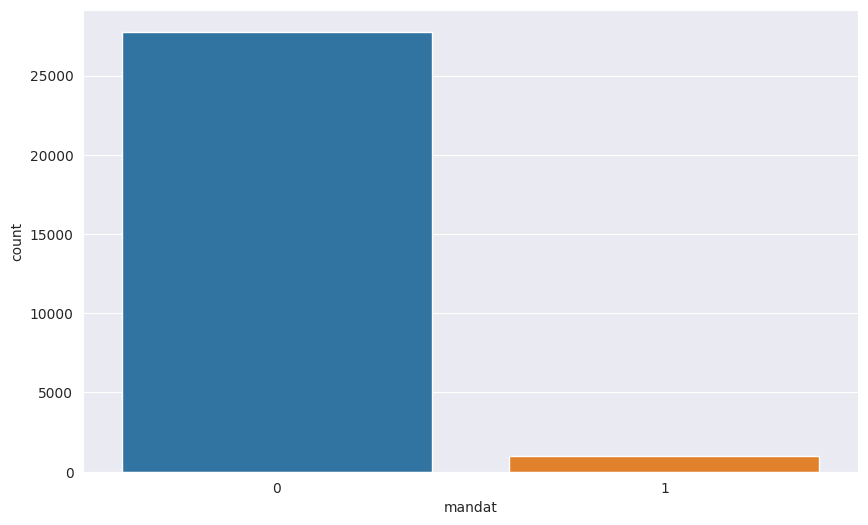

In [148]:
sns.countplot(
    data=snem_ml, x="mandat"
);
# the data is heavily unbalanced